### Library Setup

In [27]:
import os
import yfinance as yf
from vnstock import Vnstock
from typing import Tuple, List, Dict

from gymnasium import spaces
import gymnasium as gym

import torch
from torch.nn import functional as F
from torch import nn, optim

import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
from matplotlib.dates import DateFormatter
from datetime import datetime

from stable_baselines3 import SAC, PPO, A2C, TD3
from sb3_contrib import RecurrentPPO, TRPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

from joblib import Parallel, delayed
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

# Clear Cell output if your Dark Mode Client bugs

### Data Preparing

In [ ]:
def fetch_stock_data(vn_stock_list: List[str], global_stock_list: List[str], starting: str, ending: str) -> pd.DataFrame:
    # Create a full date range including weekends
    date_range = pd.date_range(start=starting, end=ending, freq='D')
    stock_data_dict = {}
    
    print(f"Fetching {len(vn_stock_list)} Vietnamese stock data...")
    for stock in vn_stock_list:
        try:
            data = Vnstock().stock(symbol=stock, source='VCI').quote.history(
                start=starting, end=ending
            )

            data.reset_index(inplace=True)
            data.rename(columns={'time': 'date'}, inplace=True)

            data['date'] = pd.to_datetime(data['date'])
            data.set_index('date', inplace=True)

            data = data[['open', 'high', 'low', 'close']]
            
            full_data = pd.DataFrame(index=date_range, columns=data.columns)
            full_data.loc[data.index] = data 
            
            # Fill gap days with evenly distributed price changes
            full_data = fill_price_gaps_evenly(full_data)
            
            # Create multi-index with stock symbol and metrics
            full_data.columns = pd.MultiIndex.from_product([[stock], full_data.columns], names=['Stock', 'Metric'])
            stock_data_dict[stock] = full_data
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            continue
    
    print(f"Fetching {len(global_stock_list)} Global stock data...")
    for stock in global_stock_list:
        try:
            data = yf.download(stock, start=starting, end=ending)
            data.index = pd.to_datetime(data.index)
        
            data = data[['Open', 'High', 'Low', 'Close']]
            data.columns = ['open', 'high', 'low', 'close']
            
            price_columns = ['open', 'high', 'low', 'close']
            data[price_columns] = data[price_columns] * 25.5  # Multiply by 25.5 for USD to VND conversion
            
            # Limit to 2 decimal places
            data[price_columns] = data[price_columns].round(2)
            
            full_data = pd.DataFrame(index=date_range, columns=data.columns)
            full_data.loc[data.index] = data
            
            # Fill gap days with evenly distributed price changes
            full_data = fill_price_gaps_evenly(full_data)
            
            # Create multi-index with stock symbol and metrics
            full_data.columns = pd.MultiIndex.from_product([[stock], full_data.columns], names=['Stock', 'Metric'])
            stock_data_dict[stock] = full_data
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            continue
    
    # Concatenate all stock data
    if stock_data_dict:
        combined_data = pd.concat(stock_data_dict.values(), axis=1)
        
        combined_data.columns = pd.MultiIndex.from_tuples(combined_data.columns, names=['Stock', 'Metric'])
        
        combined_data = combined_data.sort_index(axis=1, level='Stock')
        
        null_counts = combined_data.isnull().sum()
        if null_counts.sum() > 0:
            print("Warning: There are still NaN values in the data:")
        
        return combined_data
    else:
        raise ValueError("No stock data was successfully fetched.")


def fill_price_gaps_evenly(df):
    """
    Fill gaps in price data by evenly distributing the price change across missing days.
    
    For each gap:
    1. Find the last value before the gap and the first value after the gap
    2. Calculate the total change for each metric (open, high, low, close)
    3. Distribute this change evenly across the missing days
    """
    result = df.copy()
    
    for col_name in result.columns:
        is_nan = result[col_name].isna()
        
        if not is_nan.any():
            continue 
        
        # Find the start and end indices of each gap
        gap_starts = []
        gap_ends = []
        
        in_gap = False
        for i in range(len(is_nan)):
            if is_nan.iloc[i] and not in_gap:
                gap_starts.append(i)
                in_gap = True
            elif not is_nan.iloc[i] and in_gap:
                gap_ends.append(i)
                in_gap = False
        
        # Handle the case where the gap extends to the end of the dataframe
        if len(gap_starts) > len(gap_ends):
            gap_ends.append(len(is_nan))
        
        # Process each gap
        for start_idx, end_idx in zip(gap_starts, gap_ends):
            # Skip gaps at the beginning or end where we can't calculate a gradient
            if start_idx == 0 or end_idx == len(result):
                continue
            
            # Get values before and after the gap
            start_date = result.index[start_idx - 1]
            end_date = result.index[end_idx]
            
            start_value = result.loc[start_date, col_name]
            end_value = result.loc[end_date, col_name]
            
            # Calculate the total price change and the change per day
            total_change = end_value - start_value
            gap_length = end_idx - start_idx
            change_per_day = total_change / (gap_length + 1)  # Include the end point in calculation
            
            # Fill gap days with evenly distributed price changes
            for i in range(gap_length):
                gap_date = result.index[start_idx + i]
                gap_value = start_value + change_per_day * (i + 1)
                result.loc[gap_date, col_name] = round(gap_value, 2)
    
    # Handle any remaining NaN values at the beginning or end
    result = result.ffill().bfill()
    
    return result

### Environment

In [30]:
class CustomLoggingCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=500, save_path="plots", filename="training_rewards.pdf"):
        super(CustomLoggingCallback, self).__init__(verbose)
        self.rewards = []
        self.steps = []
        self.log_interval = log_interval
        self.save_path = save_path
        self.filename = filename

        # Ensure the save directory exists
        os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]
        step = self.num_timesteps

        self.rewards.append(reward)
        self.steps.append(step)

        if self.verbose > 0 and step % self.log_interval == 0:
            avg_reward = np.mean(self.rewards[-self.log_interval:])
            max_reward = np.max(self.rewards[-self.log_interval:])
            min_reward = np.min(self.rewards[-self.log_interval:])
            print(f"Step: {step}, Avg Reward: {avg_reward}, Max Reward: {max_reward}, Min Reward: {min_reward}")

        return True

    def _on_training_end(self) -> None:
        if self.verbose > 0:
            total_rewards = sum(self.rewards)
            print(f"Training finished. Total rewards: {total_rewards}")
            print(f"Total steps: {self.steps[-1]}")
            self.plot_training(self.rewards)

    def plot_training(self, rewards):
        sma = np.convolve(rewards, np.ones(50) / 50, mode='valid')

        plt.figure()
        plt.title("Training Rewards", fontsize=14, fontweight='bold')
        plt.plot(rewards, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Step", fontsize=12, fontweight='bold')
        plt.ylabel("Rewards", fontsize=12, fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Save the plot as PDF
        filepath = os.path.join(self.save_path, self.filename)
        plt.savefig(filepath, format='pdf')

        plt.show()
        plt.clf()
        plt.close()

In [31]:
class TradingEnv(gym.Env):
    def __init__(
        self, 
        df: pd.DataFrame,
        window_size: int, 
        frame_bound: tuple,
        initial_balance: int, 
        max_shares: int,      
        trade_max: int = 100,   
        trade_fee_percent: float = 0.001,
        risk_free_rate: float = 0.01 / 252
    ):
        self.window_size = window_size
        self.frame_bound = frame_bound
        self.initial_balance = initial_balance
        self.max_shares = max_shares
        self.trade_max = trade_max
        self.trade_fee_percent = trade_fee_percent
        self.risk_free_rate = risk_free_rate
        
        self.df = self.add_technical_indicators(df)
        
        self.prices, self.signal_features = self._process_data()
        self.shape = (self.window_size, self.signal_features.shape[1])
        super().__init__()

        # Define action space - one action per stock
        self.action_space = spaces.Box(
            low=-1,
            high=1,
            shape=(len([stock for stock in df.columns.levels[0] if stock != 'GLD']),),
            dtype=np.float64
        )
        
        # Define observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=self.shape,
            dtype=np.float64
        )
        
        # Episode state variables
        self._start_tick = None
        self._end_tick = None
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._total_reward = None
        self._total_profit = None
        self._trade_count = None
        self.history = None
        
        # Trading statistics variables
        self._balance = None
        self._shares_held = None
        self._portfolio_value = None
        self._prev_portfolio_value = None
        self._last_action = None
        self._peak_portfolio_value = None
        self._transaction_cost = None
        self._step_transaction_cost = None 

        # Reward tracking variables
        self.min_reward = None
        self.max_reward = None
        self.daily_returns = []
        
        self.reset()
        
    def add_technical_indicators(self, df: pd.DataFrame):
        """
        Add technical indicators to the dataframe
        """
        for stock in df.columns.levels[0]:
            # Bollinger Bands
            df[(stock, 'BBUpper')], df[(stock, 'BBMiddle')], df[(stock, 'BBLower')] = talib.BBANDS(
                df[(stock, 'close')], timeperiod=20, nbdevup=2, nbdevdn=2
            )
            
            # MACD
            df[(stock, 'MACD')], df[(stock, 'MACDSignal')], df[(stock, 'MACDHist')] = talib.MACD(
                df[(stock, 'close')], fastperiod=12, slowperiod=26, signalperiod=9
            )
            
            # RSI - Relative Strength Index
            df[(stock, 'RSI')] = talib.RSI(
                df[(stock, 'close')], timeperiod=14
            )
            
            # ADX - Average Directional Index
            df[(stock, 'ADX')] = talib.ADX(
                df[(stock, 'high')], df[(stock, 'low')], df[(stock, 'close')], timeperiod=14
            )
            
            # ATR - Average True Range
            df[(stock, 'ATR')] = talib.ATR(
                df[(stock, 'high')], df[(stock, 'low')], df[(stock, 'close')], timeperiod=14
            )
            
            # Stochastic Oscillator
            df[(stock, 'StochK')], df[(stock, 'StochD')] = talib.STOCHF(
                df[(stock, 'high')], df[(stock, 'low')], df[(stock, 'close')], fastk_period=14, fastd_period=3
            )
            
            # Simple Moving Averages
            df[(stock, 'SMA_20')] = talib.SMA(
                df[(stock, 'close')], timeperiod=20
            )
                        
            # Handle NaN values
            df.fillna(0.0, inplace=True)
        
        return df

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        if seed is not None:
            self.action_space.seed(int(self.np_random.uniform(0, seed)))

        # Reload processed data
        self.prices, self.signal_features = self._process_data()
        
        # Reset episode state variables
        self._start_tick = self.window_size
        self._end_tick = self.signal_features.shape[0] - 1
        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._total_reward = 0.0
        self._total_profit = 0.0
        self._trade_count = 0
        self.history = {}
        
        # Reset trading statistics
        self.daily_returns = []
        self.min_reward = float('inf')
        self.max_reward = float('-inf')
        self._balance = self.initial_balance
        self._shares_held = {stock: 0 for stock in self.df.columns.levels[0]}
        self._last_action = np.zeros(len(self.df.columns.levels[0]))
        self._transaction_cost = 0
        self._step_transaction_cost = 0
        
        # Initialize portfolio value
        self._portfolio_value = self._balance
        self._prev_portfolio_value = self._portfolio_value
        self._peak_portfolio_value = self._portfolio_value

        return self._get_observation(), self._get_info()
    
    def step(self, action):
        self._truncated = False
        self._current_tick += 1
        self._last_action = action
    
        if self._current_tick == self._end_tick:
            self._truncated = True

        # Update portfolio based on action
        self._update_profit(action)
        
        # Calculate reward
        step_reward = self._calculate_reward()
        self._total_reward += step_reward

        info = self._get_info()
        # Update trade tracking
        self._last_trade_tick = self._current_tick
        
        # Get observation and info
        observation = self._get_observation()
        
        # Update history
        self._update_history(info)
    
        return observation, step_reward, False, self._truncated, info
    
    def _get_info(self):
        """
        Return detailed information about current state
        """
        detailed_info = {
            'balance': self._balance,
            'shares_held': self._shares_held,
            'last_action': self._last_action,
            'portfolio_value': self._portfolio_value,
            'total_reward': self._total_reward,
            'total_profit': self._total_profit,
            'overall_transaction_cost': self._transaction_cost,
            'average_daily_return': np.mean(self.daily_returns) if self.daily_returns else 0, 
        }
        return detailed_info
    
    def _get_observation(self):
        """
        Return observation window of features
        """
        return self.signal_features[max(0, self._current_tick - self.window_size + 1):self._current_tick + 1]
    
    def _update_history(self, info):
        """
        Update history dictionary with info from current step
        """
        if not self.history:
            self.history = {key: [] for key in info.keys()}
        for key, value in info.items():
            self.history[key].append(value)

    def _process_data(self):
        """
        Process raw data into normalized features
        """
        raise NotImplementedError

    def _calculate_reward(self):
        """
        Calculate reward for current step
        """
        raise NotImplementedError

    def _update_profit(self, action):
        """
        Update portfolio based on action
        """
        raise NotImplementedError

In [32]:
class VnStockEnv(TradingEnv):
    def _process_data(self):
        """
        Feature processing
        """
        feature_columns = [
            'close', 'RSI', 'MACD', 'MACDSignal', 'MACDHist',
            'BBUpper', 'BBLower', 'BBMiddle', 'ADX',
            'StochK', 'StochD', 'ATR', 'SMA_20'
        ]
        prices = {}
        signal_features = pd.DataFrame()
        
        # Process each stock
        for stock in self.df.columns.levels[0]:
            # Get close prices for this stock
            prices_close = self.df[(stock, 'close')].to_numpy()
            prices_range = prices_close[self.frame_bound[0] - self.window_size : self.frame_bound[1]]
            prices[stock] = prices_range
            
            # Process existing features
            for feature in feature_columns:
                if feature in self.df.columns.levels[1]:
                    data = self.df[(stock, feature)].iloc[self.frame_bound[0] - self.window_size:self.frame_bound[1]].values
                    data = np.nan_to_num(data)
                    signal_features[(stock, feature)] = data
        
        return prices, signal_features.values

    def _calculate_reward(self) -> float:
        """
        Calculate reward using a combination of portfolio return and penalties
        """
        # Base reward is the change in portfolio value minus transaction costs
        if self._prev_portfolio_value == 0:
            return 0

        # Calculate portfolio return
        portfolio_return = (self._portfolio_value - self._prev_portfolio_value) / self._prev_portfolio_value

        # Calculate drawdown penalty
        drawdown = (self._peak_portfolio_value - self._portfolio_value) / self._peak_portfolio_value if self._peak_portfolio_value > 0 else 0
        drawdown_penalty = 0.01 * drawdown 

        # Calculate reward as return minus penalties and transaction costs
        reward = portfolio_return - drawdown_penalty - (self._step_transaction_cost / self._prev_portfolio_value) - self.risk_free_rate

        # Update min and max rewards for potential normalization
        self.min_reward = min(self.min_reward, reward)
        self.max_reward = max(self.max_reward, reward)
        
        normalized_reward = (reward - self.min_reward) / (self.max_reward - self.min_reward) if self.max_reward != self.min_reward else 0

        return normalized_reward

    def _update_profit(self, action):
        """
        Update portfolio based on action
        """
        # Store previous portfolio value for return calculation
        self._prev_portfolio_value = self._portfolio_value

        # Reset step transaction cost
        self._step_transaction_cost = 0

        # Get list of tradable stocks (excluding gold)
        tradable_stocks = [stock for stock in self.df.columns.levels[0] if stock != 'GLD']

        # Process each stock based on its corresponding action value
        for i, stock in enumerate(tradable_stocks):
            current_price = self.prices[stock][self._current_tick]

            if current_price <= 0:
                continue  # Skip invalid prices

            # Convert action from range [-1, 1] to actual shares to trade
            action_value = action[i]

            # Calculate target position based on action
            max_shares_to_trade = min(self.max_shares, self.trade_max)
            target_shares = int(action_value * max_shares_to_trade)
            shares_to_trade = target_shares - self._shares_held[stock]

            # Buy shares
            if shares_to_trade > 0:
                shares_to_buy = min(shares_to_trade, int(self._balance // current_price))
                cost = shares_to_buy * current_price
                transaction_fee = cost * self.trade_fee_percent
                total_cost = cost + transaction_fee

                if self._balance >= total_cost and shares_to_buy > 0:
                    self._balance -= total_cost
                    self._shares_held[stock] += shares_to_buy
                    self._step_transaction_cost += transaction_fee
                    self._transaction_cost += transaction_fee
                    self._trade_count += 1

            # Sell shares
            elif shares_to_trade < 0:
                shares_to_sell = min(abs(shares_to_trade), self._shares_held[stock])
                revenue = shares_to_sell * current_price
                transaction_fee = revenue * self.trade_fee_percent

                if shares_to_sell > 0:
                    self._balance += revenue - transaction_fee
                    self._shares_held[stock] -= shares_to_sell
                    self._step_transaction_cost += transaction_fee
                    self._transaction_cost += transaction_fee
                    self._trade_count += 1

        # Update portfolio value (excluding gold)
        self._portfolio_value = self._balance + sum(
            self._shares_held[stock] * self.prices[stock][self._current_tick]
            for stock in self.df.columns.levels[0])

        # Update peak portfolio value for drawdown calculation
        self._peak_portfolio_value = max(self._peak_portfolio_value, self._portfolio_value)

        # Calculate daily return
        if self._prev_portfolio_value > 0:
            daily_return = (self._portfolio_value - self._prev_portfolio_value) / self._prev_portfolio_value
            self.daily_returns.append(daily_return)

        # Calculate profit
        self._total_profit = self._portfolio_value - self.initial_balance

### Training and Testing

In [33]:
# Hyperparameter for multiple algorithms
WINDOW_SIZE = [5, 10, 15, 20, 25]

HYPERPARAMS_PPO = [
    {
        "name": "PPO",
        "policy": "MlpPolicy",
        "learning_rate": 4e-4,
        "n_steps": 2048,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.995,
        "ent_coef": 0.001,
        "clip_range": 0.2,
        "device": "cuda"
    }
]

HYPERPARAMS_A2C = [
    {
        "name": "A2C",
        "policy": "MlpPolicy",
        "learning_rate": 4e-4,
        "n_steps": 128,
        "gamma": 0.99,
        "max_grad_norm": 0.5,
        "device": "cuda"
    }
]

HYPERPARAMS_SAC = [
    {
        "name": "SAC",
        "policy": "MlpPolicy",
        "learning_rate": 4e-4,
        "buffer_size": 200000,
        "batch_size": 64,
        "gamma": 0.99,
        "tau": 0.005,
        "device": "cuda"
    }
]

HYPERPARAMS_RPPO = [
    {
        "name": "RPPO",
        "policy": "MlpLstmPolicy",
        "learning_rate": 4e-4,
        "n_steps": 512,
        "batch_size": 64,
        "gamma": 0.99,
        "clip_range": 0.2,
        "max_grad_norm": 0.5,
        "device": "cuda"
    }
]

HYPERPARAMS_TRPO = [
    {
        "name": "TRPO",
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "n_steps": 2048,
        "cg_damping": 0.1,
        "batch_size": 64,
        "gamma": 0.99,
        "target_kl": 0.01,
        "device": "cuda"
    }
]

HYPERPARAMS_TD3 = [
    {
        "name": "TD3",
        "policy": "MlpPolicy",
        "learning_rate": 4e-4,
        "buffer_size": 200000,
        "batch_size": 64,
        "gamma": 0.99,
        "tau": 0.005,
        "device": "cuda"
    }
]

In [ ]:

def create_environment(data: pd.DataFrame, window_size: int, initial_balance: float, max_shares: int, trade_max: int) -> TradingEnv:
    """Create and configure trading environment"""
    # Set up environment parameters
    frame_bound = (window_size, len(data))

    # Create environment
    env = VnStockEnv(
        df=data,
        window_size=window_size,
        frame_bound=frame_bound,
        initial_balance=initial_balance,
        max_shares=max_shares,
        trade_max=trade_max
    )
    
    # Debugging
    # print("Testing environment...")
    # action = env.action_space.sample()
    # observation, reward, done, truncated, info = env.step(action)
    # print(f"Observation shape: {observation.shape}")
        
    return env

def train_model(model_class, params: dict, data: pd.DataFrame, initial_balance: float, max_shares:  int, trade_max: int, window_size: int, timesteps: int = 500000) -> str:
    """Train a model with specific parameters"""
    # Create environment
    env = create_environment(data, window_size, initial_balance, max_shares, trade_max)
    
    # Setup monitoring
    model_name = params.pop("name")
    os.makedirs(f"models/{model_name}/{window_size}", exist_ok = True)
    os.makedirs(f"logs/{model_name}/{window_size}", exist_ok = True)
    
    env = Monitor(env, f"logs/{model_name}/{window_size}")
    env = DummyVecEnv([lambda: env])
    
    # Create callback
    callback = CustomLoggingCallback(
        verbose = 1, 
        log_interval = 20000, 
        save_path = f"models/{model_name}/{window_size}", 
        filename = f"{model_name}_{window_size}_training.pdf"
    )
    
    # Create and train model
    model = model_class(**params, env = env, verbose = 0)
    model.learn(total_timesteps = timesteps, callback = callback)
    
    # Save model
    model_path = f"models/{model_name}/{model_name}_{window_size}.zip"
    model.save(model_path)
    
    params["name"] = model_name
    
    return model_path

def evaluate_model(model_path: str, model_class, data: pd.DataFrame, initial_balance: float, max_shares: int, trade_max: int, window_size: int) -> Tuple[List[float], List[float], List[float], List[float]]:
    """Evaluate a trained model on test data"""
    # Create test environment
    env = create_environment(data, window_size, initial_balance, max_shares, trade_max)
    env = Monitor(env, None)
    env = DummyVecEnv([lambda: env])
    
    # Load model
    model = model_class.load(model_path)
    
    # Run evaluation episodes
    obs = env.reset()
    truncated = False
    
    # Track performance metrics
    portfolio_values = []
    returns = []
    actions = []
    total_profit = []
    
    while not truncated:
        action, _ = model.predict(obs)
        obs, reward, truncated, info = env.step(action)
        
        
        for i in info:
            portfolio_values.append(i['portfolio_value'])
            returns.append(i['average_daily_return'])
            actions.append(i['last_action'])
            total_profit.append(i['total_profit'])
            
    performance_metrics = calculate_metrics(portfolio_values, returns, initial_balance)
            
    # Save results
    model_name = model_path.split('/')[-2]
    os.makedirs(f"logs/{model_name}/{window_size}", exist_ok=True)
    
    results_df = pd.DataFrame({
        'Trading Day': range(len(portfolio_values)),
        'Portfolio Value': portfolio_values,
        'Daily Return': returns,
        'Total Profit': total_profit
    })
    
    results_df.to_csv(f"logs/{model_name}/{window_size}/evaluation.csv", index=False)
    
    return {
        "portfolio_values": portfolio_values,
        "returns": returns,
        "actions": actions,
        "total_profit": total_profit,
        "performance_metrics": performance_metrics
    }

In [ ]:
def calculate_metrics(portfolio_values: List[float], returns: List[float], initial_balance: float) -> Dict:
    """
    Calculate trading performance metrics
    """
    if not portfolio_values or not returns:
        return {
            "cumulative_return": 0,
            "max_drawdown": 0,
            "annual_return": 0,
            "sharpe_ratio": 0,
            "calmar_ratio": 0,
            "sortino_ratio": 0,
            "win_rate": 0
        }
    portfolio_values = np.array(portfolio_values)
    returns = np.array(returns)
    
    # Cumulative return
    cumulative_return = (portfolio_values[-1] - initial_balance) / initial_balance
    
    # Maximum drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    
    # Annual return (assuming 252 trading days per year)
    n_days = len(portfolio_values)
    annual_return = ((1 + cumulative_return) ** (252 / n_days)) - 1
    
    # Risk-free rate
    risk_free_rate = 0.01
    
    # Sharpe ratio
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = daily_returns - (risk_free_rate / 252)  # Daily risk-free rate
    sharpe_ratio = np.sqrt(252) * np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) > 0 else 0
    
    # Calmar ratio
    calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else 0
    
    # Sortino ratio (using downside deviation)
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = np.std(negative_returns) if len(negative_returns) > 0 else 0
    sortino_ratio = np.sqrt(252) * np.mean(excess_returns) / downside_deviation if downside_deviation > 0 else 0
    
    # Win rate
    win_count = np.sum(daily_returns > 0)
    total_trades = len(daily_returns)
    win_rate = win_count / total_trades if total_trades > 0 else 0
    
    return {
        "cumulative_return": cumulative_return,
        "max_drawdown": max_drawdown,
        "annual_return": annual_return,
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "sortino_ratio": sortino_ratio,
        "win_rate": win_rate
    }

In [ ]:
def plot_portfolio_performance(
    results: Dict[str, Dict[str, Dict]], 
    save_path: str = "plots"
) -> None:
    """
    Plot portfolio performance visualizations organized by model
    
    Parameters:
    - results: Nested dictionary containing model results
    - save_path: Directory to save plots
    """
    os.makedirs(save_path, exist_ok=True)
    
    color_palette = {
        "PPO": {
            "5": "#003f5c",    # Deep navy blue
            "10": "#2f4b7c",   # Royal blue
            "15": "#665191",   # Blue-violet
            "20": "#a05195",   # Purple-magenta
            "25": "#d45087"    # Pink-magenta
        },
        "A2C": {
            "5": "#7c0000",    # Deep burgundy
            "10": "#a63603",   # Dark rust
            "15": "#e6550d",   # Burnt orange
            "20": "#fd8d3c",   # Medium orange
            "25": "#fdbe85"    # Light peach
        },
        "RPPO": {
            "5": "#004529",    # Deep forest green
            "10": "#006837",   # Dark green
            "15": "#238443",   # Medium green
            "20": "#41ab5d",   # Bright green
            "25": "#78c679"    # Light green
        },
        "TRPO": {
            "5": "#4a0058",    # Dark purple
            "10": "#7a0177",   # Rich purple
            "15": "#ae017e",   # Magenta
            "20": "#dd3497",   # Bright pink
            "25": "#f768a1"    # Light pink
        },
        "SAC": {
            "5": "#8c510a",    # Dark brown
            "10": "#d8b365",   # Light brown
            "15": "#f6e8c3",   # Pale yellow
            "20": "#5ab4ac",   # Teal
            "25": "#01665e"    # Dark teal
        },
        "TD3": {
            "5": "#016c73",    # Dark teal
            "10": "#2ca25f",   # Medium green
            "15": "#99d8c9",   # Light teal
            "20": "#f7f7f7",   # Light gray
            "25": "#d95f0e"    # Orange
        }
    }

    line_styles = ['-', '--', '-.', ':']
    
    # Set style for all plots
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16
    })

    model_performance = []
    for model_name, window_sizes in results.items():
        for window_size, metrics in window_sizes.items():
            perf_metrics = metrics["performance_metrics"]
            performance_score = perf_metrics["sharpe_ratio"] * (1 + perf_metrics["cumulative_return"])
            model_performance.append((model_name, window_size, performance_score))
    
    model_performance.sort(key=lambda x: x[2], reverse=True)
    
    # Create individual plots for each model
    for model_name in results.keys():
        model_path = os.path.join(save_path, model_name)
        os.makedirs(model_path, exist_ok=True)
        
        # 1. Cumulative Returns Plot
        fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
        
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
        
        ax.grid(True)
        
        for window_size in results[model_name].keys():
            # Get data
            portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
            initial_value = portfolio_values[0]
            cumulative_returns = (portfolio_values / initial_value) - 1
            
            # Get color from palette
            color = color_palette[model_name][str(window_size)]
            
            # Plot
            label = f"Window Size: {window_size}"
            ax.plot(cumulative_returns, label=label, 
                    linewidth=2.5, 
                    color=color)
        
        ax.set_title(f'{model_name} - Cumulative Returns by Window Size', fontweight='bold')
        ax.set_xlabel('Trading Days')
        ax.set_ylabel('Cumulative Return')
        
        # Add percentage formatting to y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Clean legend
        ax.legend(loc='upper left', frameon=True, fancybox=False, 
                  edgecolor='black', facecolor='white', framealpha=1.0)
        
        # Set spine colors to black
        for spine in ax.spines.values():
            spine.set_color('black')
        
        plt.tight_layout()
        plt.savefig(f"{model_path}/cumulative_returns.png", dpi=300)
        plt.close()
        
        # 2. Drawdown Analysis
        fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
        
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
        
        ax.grid(True)
        
        for window_size in results[model_name].keys():
            # Get data
            portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
            peak = np.maximum.accumulate(portfolio_values)
            drawdown = (peak - portfolio_values) / peak
            
            # Get color from palette
            color = color_palette[model_name][str(window_size)]
            
            # Plot
            label = f"Window Size: {window_size}"
            ax.plot(drawdown, label=label, 
                    linewidth=2.5, 
                    color=color)
        
        ax.set_title(f'{model_name} - Drawdown Analysis by Window Size', fontweight='bold')
        ax.set_xlabel('Trading Days')
        ax.set_ylabel('Drawdown')
        
        # Add percentage formatting to y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Clean legend
        ax.legend(loc='lower left', frameon=True, fancybox=False, 
                  edgecolor='black', facecolor='white', framealpha=1.0)
        
        # Set spine colors to black
        for spine in ax.spines.values():
            spine.set_color('black')
        
        plt.tight_layout()
        plt.savefig(f"{model_path}/drawdown.png", dpi=300)
        plt.close()
        
        # 3. Performance Metrics Heatmap
        metrics_df = []
        
        for window_size, metrics in results[model_name].items():
            perf_metrics = metrics["performance_metrics"]
            row = {
                "Window Size": window_size,
                "Cumulative Return": perf_metrics["cumulative_return"],
                "Max Drawdown": perf_metrics["max_drawdown"],
                "Annual Return": perf_metrics["annual_return"],
                "Sharpe Ratio": perf_metrics["sharpe_ratio"],
                "Calmar Ratio": perf_metrics["calmar_ratio"],
                "Sortino Ratio": perf_metrics["sortino_ratio"],
                "Win Rate": perf_metrics["win_rate"]
            }
            metrics_df.append(row)
        
        metrics_df = pd.DataFrame(metrics_df)
        
        # Sort by Sharpe ratio
        metrics_df = metrics_df.sort_values(by='Sharpe Ratio', ascending=False)
        metrics_df.set_index("Window Size", inplace=True)
        
        # Create heatmap with professional styling
        plt.figure(figsize=(10, len(metrics_df) * 0.8), dpi=300)
        
        cmap = plt.cm.RdYlBu
        
        # Create the heatmap
        sns.heatmap(metrics_df, annot=True, cmap=cmap, fmt=".3f", 
                    linewidths=0.5, cbar=True, center=0,
                    annot_kws={"size": 9})
        
        plt.title(f'{model_name} - Performance Metrics by Window Size', fontweight='bold')
        plt.tight_layout()
        plt.savefig(f"{model_path}/performance_metrics_heatmap.png", dpi=300)
        plt.close()
    
    # 4. Performance Metrics Table for all models
    metrics_df = []
    
    for model_name, window_sizes in results.items():
        for window_size, metrics in window_sizes.items():
            perf_metrics = metrics["performance_metrics"]
            row = {
                "Model": f"{model_name}_{window_size}",
                "Cumulative Return": perf_metrics["cumulative_return"],
                "Max Drawdown": perf_metrics["max_drawdown"],
                "Annual Return": perf_metrics["annual_return"],
                "Sharpe Ratio": perf_metrics["sharpe_ratio"],
                "Calmar Ratio": perf_metrics["calmar_ratio"],
                "Sortino Ratio": perf_metrics["sortino_ratio"],
                "Win Rate": perf_metrics["win_rate"]
            }
            metrics_df.append(row)
    
    metrics_df = pd.DataFrame(metrics_df)
    
    # Create table figure
    fig, ax = plt.subplots(figsize=(10, len(metrics_df) * 0.4 + 1), dpi=300)
    ax.axis('off')
    
    # Create table
    table = ax.table(
        cellText=metrics_df.iloc[:, 1:].values,
        rowLabels=metrics_df['Model'],
        colLabels=metrics_df.columns[1:],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#e6e6e6')
        elif col == -1:  # Row labels
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#e6e6e6')
        if row > 0 and col >= 0:  # Format numbers
            text = cell.get_text().get_text()
            try:
                val = float(text)
                if col == 0:  # Cumulative Return
                    cell.get_text().set_text(f"{val:.2%}")
                elif col == 1:  # Max Drawdown
                    cell.get_text().set_text(f"{val:.2%}")
                elif col == 2:  # Annual Return
                    cell.get_text().set_text(f"{val:.2%}")
                elif col == 6:  # Win Rate
                    cell.get_text().set_text(f"{val:.2%}")
                else:  # Other ratios
                    cell.get_text().set_text(f"{val:.3f}")
            except ValueError:
                pass
    
    plt.title('Performance Metrics Comparison - All Models', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/performance_metrics_table.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Performance Metrics Bar Chart for top models
    # Focus on top 5 models by Sharpe ratio
    top_models = metrics_df.sort_values('Sharpe Ratio', ascending=False).head(5)['Model']
    top_metrics = metrics_df[metrics_df['Model'].isin(top_models)].set_index('Model')
    
    # Key metrics to visualize
    key_metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio"]
    
    fig, axes = plt.subplots(len(key_metrics), 1, figsize=(8, 9), sharex=True, dpi=300)
    
    # White background
    fig.patch.set_facecolor('white')
    
    for i, metric in enumerate(key_metrics):
        ax = axes[i]
        ax.set_facecolor('white')
        
        # Extract model components for coloring
        model_components = [model.split('_') for model in top_metrics.index]
        model_types = [comp[0] for comp in model_components]
        
        # Create bars with custom colors
        bars = ax.bar(top_metrics.index, top_metrics[metric])
        
        # Color bars according to model type
        for j, bar in enumerate(bars):
            model_type = model_types[j]
            window = model_components[j][1]
            bar.set_color(color_palette[model_type][window])
            
        ax.set_title(f'{metric} - Top 5 Models', fontweight='bold')
        ax.set_ylabel(metric)
        ax.grid(True)
        
        # Set spine colors to black
        for spine in ax.spines.values():
            spine.set_color('black')
            
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{save_path}/top_models_comparison.png", dpi=300)
    plt.close()

In [ ]:
def generate_results_dashboard(results: Dict[str, Dict[str, Dict]], save_path: str = "plots") -> None:
    """
    Generate a comprehensive trading performance dashboard
    
    Parameters:
    - results: Nested dictionary containing model results
    - save_path: Directory to save plots
    """
    os.makedirs(save_path, exist_ok=True)
    
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.titlesize': 14
    })
    
    color_palette = {
        "PPO": "#1f77b4",    # Blue
        "A2C": "#d62728",    # Red
        "RPPO": "#2ca02c",   # Green
        "TRPO": "#9467bd",    # Purple
        "SAC": "#8c564b",    # Brown
        "TD3": "#e377c2"     # Pink
    }
    
    # Calculate performance metrics for ordering
    model_performance = []
    for model_name, window_sizes in results.items():
        for window_size, metrics in window_sizes.items():
            perf_metrics = metrics["performance_metrics"]
            performance_score = perf_metrics["sharpe_ratio"] * (1 + perf_metrics["cumulative_return"])
            model_performance.append((model_name, window_size, performance_score))
    
    # Sort models by performance
    model_performance.sort(key=lambda x: x[2], reverse=True)
    
    # Create dashboard with multiple subplots
    fig = plt.figure(figsize=(11, 8.5), dpi=300)
    fig.patch.set_facecolor('white')
    
    gs = gridspec.GridSpec(2, 3, figure=fig)
    
    # 1. Top Left: Cumulative Returns Plot (top performers)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_facecolor('white')
    ax1.grid(True)
    
    # Plot only top 5 performers for clarity
    for i, (model_name, window_size, _) in enumerate(model_performance[:5]):
        portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
        initial_value = portfolio_values[0]
        cumulative_returns = (portfolio_values / initial_value) - 1
        
        label = f"{model_name}_{window_size}"
        ax1.plot(cumulative_returns, label=label, 
                linewidth=2, 
                color=color_palette[model_name],
                alpha=0.9)
    
    ax1.set_title('Cumulative Returns (Top Models)', fontweight='bold')
    ax1.set_xlabel('Trading Days')
    ax1.set_ylabel('Cumulative Return')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax1.legend(loc='upper left', frameon=True, fancybox=False, 
              edgecolor='black', facecolor='white', framealpha=1.0)
    
    # Set spine colors to black
    for spine in ax1.spines.values():
        spine.set_color('black')
    
    # 2. Top Middle: Drawdown Analysis (top performers)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_facecolor('white')
    ax2.grid(True)
    
    for i, (model_name, window_size, _) in enumerate(model_performance[:5]):
        portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (peak - portfolio_values) / peak
        
        label = f"{model_name}_{window_size}"
        ax2.plot(drawdown, label=label, 
                linewidth=2, 
                color=color_palette[model_name],
                alpha=0.9)
    
    ax2.set_title('Drawdown Analysis (Top Models)', fontweight='bold')
    ax2.set_xlabel('Trading Days')
    ax2.set_ylabel('Drawdown')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Set spine colors to black
    for spine in ax2.spines.values():
        spine.set_color('black')
    
    # 3. Top Right: Sharpe Ratio Comparison (top 10)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_facecolor('white')
    ax3.grid(True, axis='y')
    
    # Get top 10 models by Sharpe ratio
    top_models = model_performance[:10]
    model_labels = [f"{model}_{window}" for model, window, _ in top_models]
    sharpe_values = [results[model][window]["performance_metrics"]["sharpe_ratio"] 
                    for model, window, _ in top_models]
    
    # Determine colors based on model type
    bar_colors = [color_palette[model] for model, _, _ in top_models]
    
    # Create horizontal bar chart
    bars = ax3.barh(model_labels, sharpe_values, color=bar_colors, alpha=0.8)
    
    ax3.set_title('Sharpe Ratio Comparison', fontweight='bold')
    ax3.set_xlabel('Sharpe Ratio')
    ax3.tick_params(axis='y', labelsize=8)  # Smaller font for model names
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax3.text(width + 0.05, 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', 
                va='center', 
                fontsize=8)
    
    # Set spine colors to black
    for spine in ax3.spines.values():
        spine.set_color('black')
    
    # 4. Bottom Left: Annual Return vs Max Drawdown
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.set_facecolor('white')
    ax4.grid(True)
    
    # Extract data for scatter plot
    model_types = []
    window_sizes = []
    annual_returns = []
    max_drawdowns = []
    sharpe_ratios = []
    
    for model_name, window_dict in results.items():
        for window_size, metrics in window_dict.items():
            perf = metrics["performance_metrics"]
            model_types.append(model_name)
            window_sizes.append(window_size)
            annual_returns.append(perf["annual_return"])
            max_drawdowns.append(perf["max_drawdown"])
            sharpe_ratios.append(perf["sharpe_ratio"])
    
    # Size points by Sharpe ratio
    sizes = [max(30 * (1 + sr), 20) for sr in sharpe_ratios]
    
    # Color points by model type
    colors = [color_palette[mt] for mt in model_types]
    
    # Create scatter plot
    scatter = ax4.scatter(max_drawdowns, annual_returns, s=sizes, c=colors, alpha=0.7)
    
    # Add labels for each point
    for i, (mt, ws) in enumerate(zip(model_types, window_sizes)):
        if i < 5:  # Label only top 5 models for clarity
            ax4.annotate(f"{mt}_{ws}", 
                        (max_drawdowns[i], annual_returns[i]),
                        fontsize=7, ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points')
    
    ax4.set_title('Risk-Return Profile', fontweight='bold')
    ax4.set_xlabel('Maximum Drawdown')
    ax4.set_ylabel('Annual Return')
    ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Create custom legend for model types
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=8, 
                                 label=model) for model, color in color_palette.items()]
    ax4.legend(handles=legend_elements, loc='upper right', frameon=True, 
              fancybox=False, edgecolor='black', fontsize=7)
    
    # Set spine colors to black
    for spine in ax4.spines.values():
        spine.set_color('black')
    
    # 5. Bottom Middle: Win Rate vs. Sortino Ratio
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.set_facecolor('white')
    ax5.grid(True)
    
    # Extract data
    win_rates = []
    sortino_ratios = []
    
    for model_name, window_dict in results.items():
        for window_size, metrics in window_dict.items():
            perf = metrics["performance_metrics"]
            win_rates.append(perf["win_rate"])
            sortino_ratios.append(perf["sortino_ratio"])
    
    # Create scatter plot
    scatter = ax5.scatter(win_rates, sortino_ratios, s=sizes, c=colors, alpha=0.7)
    
    # Add labels for top models
    for i, (mt, ws) in enumerate(zip(model_types, window_sizes)):
        if i < 5:  # Label only top 5 models
            ax5.annotate(f"{mt}_{ws}", 
                        (win_rates[i], sortino_ratios[i]),
                        fontsize=7, ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points')
    
    ax5.set_title('Win Rate vs Sortino Ratio', fontweight='bold')
    ax5.set_xlabel('Win Rate')
    ax5.set_ylabel('Sortino Ratio')
    ax5.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    
    # Set spine colors to black
    for spine in ax5.spines.values():
        spine.set_color('black')
    
    # 6. Bottom Right: Performance Metrics Table
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    # Create data for table - top 5 models
    metrics_df = []
    for model_name, window_size, _ in model_performance[:5]:
        perf_metrics = results[model_name][window_size]["performance_metrics"]
        row = {
            "Model": f"{model_name}_{window_size}",
            "Return": f"{perf_metrics['cumulative_return']:.3f}",
            "Sharpe": f"{perf_metrics['sharpe_ratio']:.3f}",
            "Sortino": f"{perf_metrics['sortino_ratio']:.3f}",
            "Calmar": f"{perf_metrics['calmar_ratio']:.3f}",
            "Win Rate": f"{perf_metrics['win_rate']:.3f}"
        }
        metrics_df.append(row)
    
    metrics_df = pd.DataFrame(metrics_df)
    
    # Create table
    table = ax6.table(
        cellText=metrics_df.iloc[:, 1:].values,
        rowLabels=metrics_df['Model'],
        colLabels=metrics_df.columns[1:],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#e6e6e6')
        elif col == -1:  # Row labels
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#e6e6e6')
    
    ax6.set_title('Top 5 Models - Performance Metrics', fontweight='bold', pad=20)
    
    # Main title
    plt.suptitle('Trading Performance Dashboard', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"{save_path}/trading_dashboard.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def run_evaluation(model_paths: List[str], models_info: Dict, test_data: pd.DataFrame) -> Dict:
    """
    Run evaluation on multiple models and return consolidated results
    """
    results = {}
    
    for model_path in model_paths:
        model_class = models_info[model_path]["model_class"]
        window_size = models_info[model_path]["window_size"]
        model_name = model_path.split('/')[-2]
        
        print(f"Evaluating {model_name} with window size {window_size}...")
        
        evaluation_results = evaluate_model(
            model_path=model_path,
            model_class=model_class,
            data=test_data,
            initial_balance=3000,
            max_shares=10000,
            trade_max=100,
            window_size=window_size
        )
        
        if model_name not in results:
            results[model_name] = {}
        
        results[model_name][window_size] = evaluation_results
    
    return results

### Evaluate / Visualize

Number of stocks using: 39

--- PROCESSING TRAINING DATA ---
Fetching train stock data...
Fetching 14 Vietnamese stock data...


[*********************100%***********************]  1 of 1 completed

Fetching 25 Global stock data...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


--- PROCESSING TEST DATA ---
Fetching test stock data...
Fetching 14 Vietnamese stock data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching 25 Global stock data...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Data processing completed successfully.

Training PPO models...
  Training PPO_5...
Step: 20000, Avg Reward: 0.41036665439605713, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4137057960033417, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.410794198513031, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4513527452945709, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.42619526386260986, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.4532473087310791, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.42225396633148193, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.43879008293151855, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.42244207859039307, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.4062615633010864, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.41383275389671326, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.45404183864593506

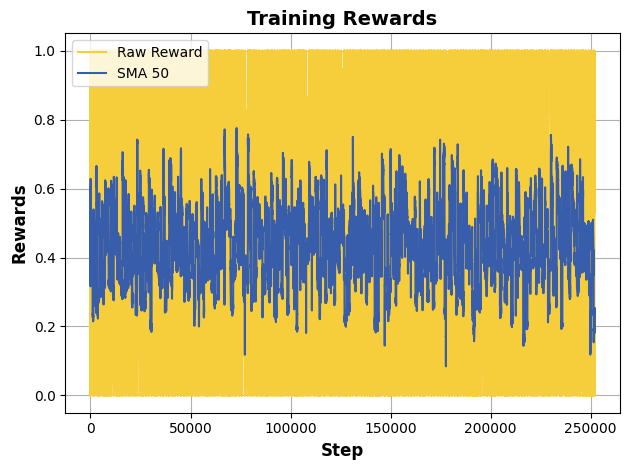

  Training PPO_10...
Step: 20000, Avg Reward: 0.417253702878952, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.43506649136543274, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4283035099506378, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4488430321216583, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.44977933168411255, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.4484485387802124, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.4354569911956787, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.45064589381217957, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4281483292579651, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.43954965472221375, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.4028637111186981, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4116460382938385, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewards

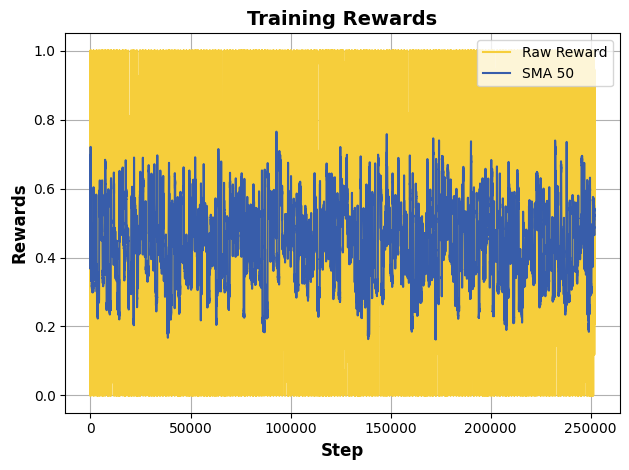

  Training PPO_15...
Step: 20000, Avg Reward: 0.40754908323287964, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4234977066516876, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4032151997089386, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.44536763429641724, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.40769654512405396, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.417613685131073, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.38459092378616333, Max Reward: 1.0, Min Reward: 0.0


In [ ]:
def main():
    # Stock data configuration
    STOCK_LIST_VN = ['FPT', 'VCB', 'VIC', 'GAS', 'VHM', 'BID', 'MBB', 'HVN', 'HPG', 'GVR', 'VNM', 'SSI', 'GEX', 'ACB']
    STOCK_LIST_US = ['AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HON', 'IBM', 'INTC', 'JPM', 'MSFT', 'NKE', 'GOOGL', 'AMZN', 'WMT', 'NVDA']
    STOCK_LIST_CN = ['BABA', 'JD', 'PDD', 'NTES', 'BIDU', 'NIO', 'XPEV', 'LI']
    STOCK_LIST_GLOBAL = STOCK_LIST_US + STOCK_LIST_CN
    
    # Date ranges
    TRAIN_START_DATE = '2020-01-01'
    TRAIN_END_DATE = '2024-01-01'
    TEST_START_DATE = '2024-01-01'
    TEST_END_DATE = '2025-03-15'
    
    
    print(f"Number of stocks using: {len(STOCK_LIST_VN) + len(STOCK_LIST_GLOBAL)}")
    
    # Process training data
    print("\n--- PROCESSING TRAINING DATA ---")
    
    # Fetch stock data
    print("Fetching train stock data...")
    train_stock_data = fetch_stock_data(
        STOCK_LIST_VN, 
        STOCK_LIST_GLOBAL, 
        TRAIN_START_DATE, 
        TRAIN_END_DATE
    )
    
    print("\n--- PROCESSING TEST DATA ---")
    
    print("Fetching test stock data...")
    test_stock_data = fetch_stock_data(
        STOCK_LIST_VN, 
        STOCK_LIST_GLOBAL, 
        TEST_START_DATE, 
        TEST_END_DATE
    )
    
    print("\nData processing completed successfully.")

    # Create directories
    os.makedirs("models", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    
    # Dictionary to store results for all models
    all_results = {}
    
    # Define model classes and their hyperparameter lists
    models_to_train = [
        (PPO, HYPERPARAMS_PPO),
        (A2C, HYPERPARAMS_A2C),
        (RecurrentPPO, HYPERPARAMS_RPPO),
        (TRPO, HYPERPARAMS_TRPO),
        (SAC, HYPERPARAMS_SAC), # 40000 timesteps
        (TD3, HYPERPARAMS_TD3),
    ]
    
    model_paths = []
    models_info = {}
    
    # Train all models with different hyperparameters
    for model_class, hyperparams_list in models_to_train:
        model_type = model_class.__name__
        print(f"\nTraining {model_type} models...")
        
        for params in hyperparams_list:
            for win_size in WINDOW_SIZE:
                model_name = params["name"]
                print(f"  Training {model_name}_{win_size}...")

                # Create a copy of params to avoid modifying the original
                params_copy = params.copy()

                # # Train model
                model_path = train_model(
                    model_class=model_class,
                    params=params_copy,
                    data=train_stock_data,
                    initial_balance=5000,
                    max_shares=10000,
                    trade_max=100,
                    timesteps=250000,
                    window_size=win_size
                )
                
                model_paths.append(model_path)
                models_info[model_path] = {
                    "model_class": model_class,
                    "window_size": win_size
                }
    
    results = run_evaluation(model_paths, models_info, test_stock_data)
    
    # Generate visualizations
    plot_portfolio_performance(results)
    generate_results_dashboard(results)
    
    print("Evaluation and visualization completed!")
if __name__ == "__main__":
    main()